## <div style="border: 1px solid purple; padding: 10px; color: SteelBlue"> 1.Import</div>

In [1]:
!pip -q install scikit-survival

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 23.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import zipfile
import io
import os
import numpy as np
import gc
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno
import seaborn as sns
import pickle

from sksurv.util import Surv
from sksurv.ensemble import RandomSurvivalForest
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# pd.set_option('display.max_rows',None)
# pd.set_option('display.max_columns',None)
pd.options.display.float_format ='{:,.2f}'.format
plt.rcParams["figure.figsize"] = (12, 12)

In [3]:
df = pd.read_csv('df_2021_2024.csv')

<ipython-input-3-4a487af4cff0>:1: DtypeWarning: Columns (95,98) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('df_2021_2024.csv')


Добавление колонки с периодом

In [5]:
def append_period_col(df):
    """Функция добавляющая колонку с периодои между датой начала исследования и датой
    последней записи по каждому диску"""
    df["date"] = pd.to_datetime(df["date"])
    first_date = pd.to_datetime("01-01-2021")
    df["days_between"] = df.groupby("serial_number")["date"].transform(
        lambda x: (x.max() - x.min()).days if x.max() != x.min() else (x.max() - first_date).days
    )
    return df

In [6]:
df = append_period_col(df)

In [7]:
df.shape

(31036, 106)

In [8]:
df.describe(include='object')

,serial_number,model,is_legacy_format,datacenter
count,31036,31036,12491,9662
unique,11875,68,1,5
top,8CH4AUJE,ST12000NM0008,False,sac0
freq,15,4103,12491,3566


## <div style="border: 1px solid purple; padding: 10px; color: SteelBlue"> 2. EDA</div>

In [9]:
df.drop(columns=['Unnamed: 0'], inplace=True)

Соединим с файлом, где есть типы дисков.

In [10]:
models = pd.read_csv('models.csv')

In [11]:
df = df.merge(models, on='model')

In [12]:
df['type'].isna().sum()

0

In [13]:
df.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_raw,smart_2_raw,smart_3_raw,smart_4_raw,smart_5_raw,...,smart_90_raw,datacenter,cluster_id,pod_slot_num,smart_27_raw,smart_82_raw,smart_211_raw,smart_212_raw,days_between,type
0,2021-02-17,ZA153THY,ST8000NM0055,8001563222016,1,"192,214,128.00",NaN,0.00,8.00,"15,584.00",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47,HDD
1,2021-02-17,40T0A007F97G,TOSHIBA MG07ACA14TA,14000519643136,1,0.00,0.00,"7,832.00",22.00,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47,HDD
2,2021-02-17,PL1331LAHBS5JH,HGST HMS5C4040BLE640,4000787030016,1,0.00,100.00,419.00,9.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47,HDD
3,2021-02-17,ZA11WLX1,ST8000DM002,8001563222016,1,"136,748,944.00",NaN,0.00,15.00,"14,963.00",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47,HDD
4,2021-02-17,1080A12QF9RG,TOSHIBA MG07ACA14TEY,14000519643136,1,0.00,0.00,"6,992.00",34.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47,HDD


In [14]:
df.shape

(30901, 106)

In [15]:
print(f"Количество дубликатов: {df[df.duplicated()].shape[0]}")

Количество дубликатов: 0


Эти столбцы описаны владельцем датасета и представляют ценность в рамках его бизнеса.\
Их можно удалить.
- Vault_id: All data drives are members of a Backblaze Vault. Each vault consists of either 900 or 1,200 hard drives divided evenly across 20 storage servers.  The vault is a numeric value starting at 1,000.
- Pod_id: There are 20 storage servers in each Backblaze Vault. The Pod_id is a numeric field with values from 0 to 19 assigned to one of the 20 storage servers.
- Is_legacy_format: Currently 0, but will be useful over the coming quarters as more fields are added.
- datacenter: The Backblaze data center where the drive is installed, currently one of these values: ams5, iad1, phx1, sac0, and sac2.
- cluster_id: The name of a given collection of storage servers logically grouped together to optimize system performance. Note: At this time the cluster_id is not always correct, we are working on fixing that.
- pod_slot_num: The physical location of a drive within a storage server. The specific slot differs based on the storage server type and capacity: Backblaze (45 drives), Backblaze (60 drives), Dell (26 drives), or Supermicro (60 drives). We’ll dig into these differences in another post.

In [16]:
df.drop(
    columns=[
        "vault_id",
        "pod_id",
        "is_legacy_format",
        "datacenter",
        "cluster_id",
        "pod_slot_num",
    ],
    errors="ignore",
    inplace=True
)

Также можно удалить строки с пропусками по всем датчикам.

In [17]:
df = df.dropna(subset=(df.filter(regex='raw').columns).to_list(), how='all')

In [18]:
df.groupby(['days_between'])['failure'].sum().to_frame().T

days_between,0,1,2,3,4,5,6,7,8,9,...,1262,1265,1266,1267,1269,1270,1272,1273,1274,1275
failure,4,14,13,20,11,13,16,19,16,15,...,2,3,4,3,1,1,2,3,1,3


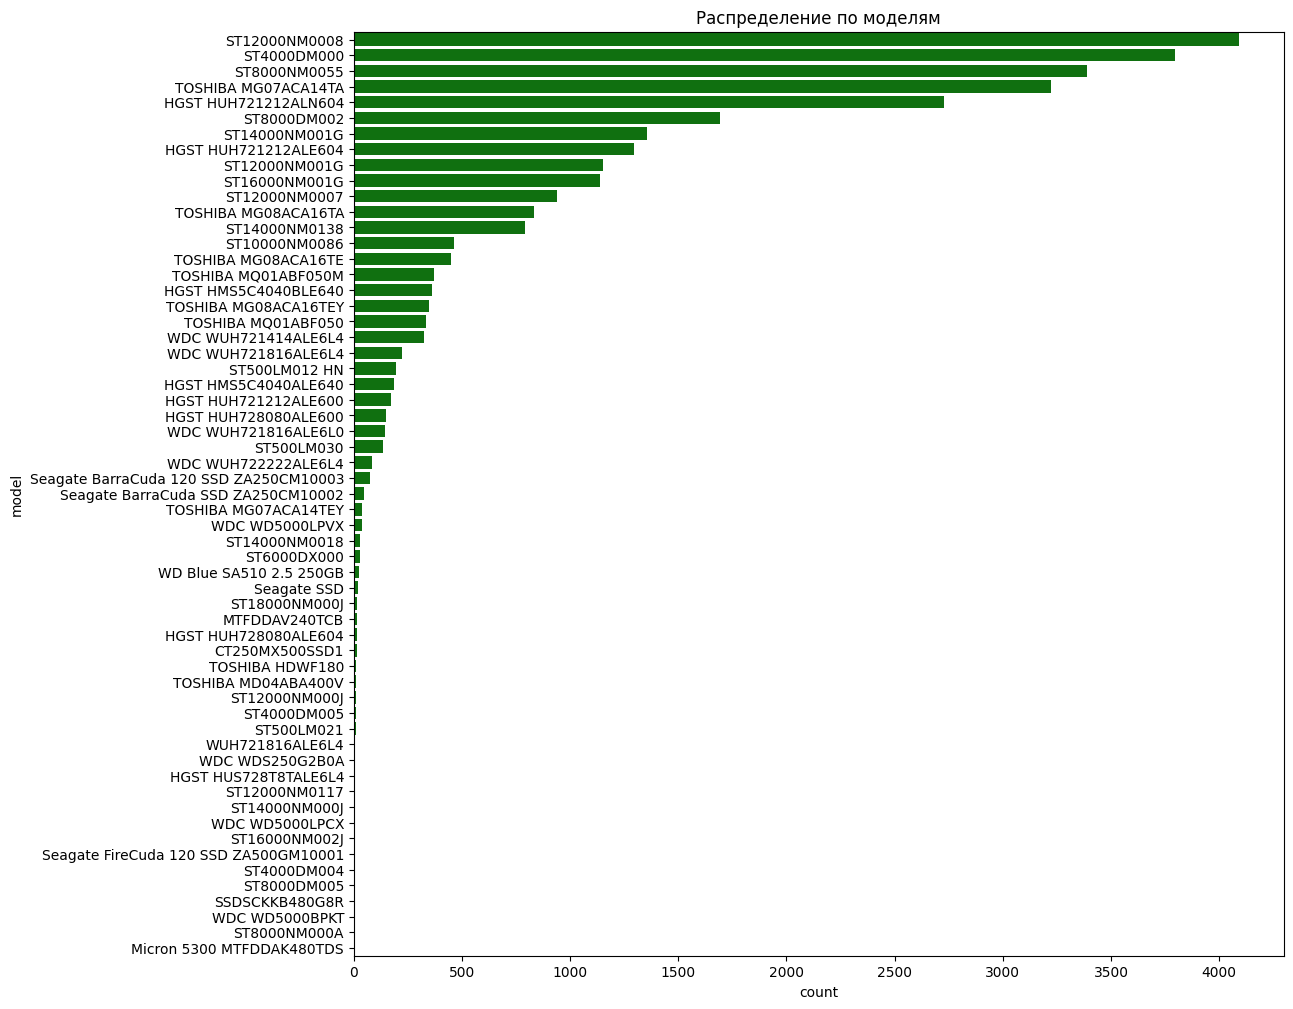

In [19]:
plt.title('Распределение по моделям')
sns.barplot(df.model.value_counts(), color='g', orient='h', )
plt.show()

Видно, что модели в датасете представлены не равномерно, поэтому использовать данный признак для предсказания не стоит.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


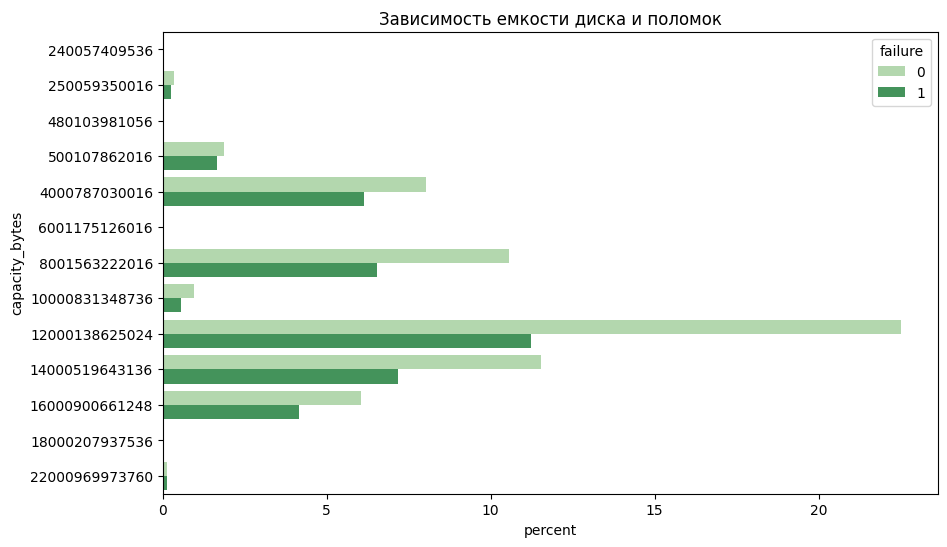

In [20]:
plt.figure(figsize=(10,6))
plt.title('Зависимость емкости диска и поломок')
sns.countplot(df, y='capacity_bytes', hue='failure',palette='Greens', stat='percent')
plt.show()

Зависимость от емкости диска на первый взляд не видна.

Посмотрим картину по пропускам.

<Axes: >

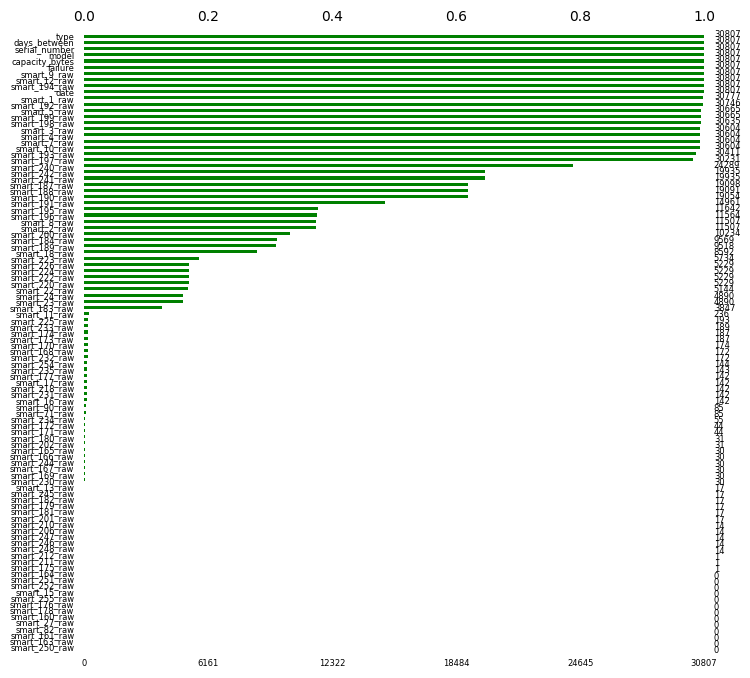

In [21]:
msno.bar(df, color="green", figsize=(8, 8), fontsize=6, sort='ascending')

Мы видим, что около половины признаков имеют количество пропусков, стремящееся к 100%.\
Есть датчики, которые снимают показания только с дисков SSD. Есть смысл разделить данные по типам дисков.

<div class="alert alert-success">
<h3>Вывод:</h3>
Согласно информации по датчикам SMART есть датчики, которые используются только для SSD дисков. Некорректно будет заполнять пропущенные значения по HDD дискам в случае физического отсутствия на них датчика.
План:
- Разделим данные по типу диска
- Выделим наиболее важные признаки для каждого типа
- Обозначим общие важные признаки для обоих типов

## <div style="border: 1px solid purple; padding: 10px; color: SteelBlue"> 3. Features importances</div>

### SSD

In [22]:
mask  = df["type"] == 'SSD'

In [23]:
df_ssd = df[mask]

In [24]:
df_ssd.failure.value_counts()

,count
failure,
0,112
1,91


Удалим столбцы с кол-вом пропусков более 30%.

In [25]:
missing_cols = (df_ssd.isnull().mean() * 100).to_frame(name='null').reset_index()
missing_cols.shape

(100, 2)

In [26]:
cols_to_del = missing_cols.loc[missing_cols['null'] > 30]
cols_to_del.shape

(80, 2)

In [27]:
df_ssd = df_ssd.drop(columns=cols_to_del.iloc[:, 0])

In [28]:
df_ssd.drop(columns=['serial_number', 'date', 'type'], inplace=True)

Проверим колонки, где одно уникальное значение.

In [29]:
for col in df_ssd.columns:
  if df_ssd[col].nunique() == 1:
    print(f'{col} {df_ssd[col].isna().sum()}')

##### Correlation

Посмотрим на корреляцию между признаками.

In [30]:
corr_matrix = df_ssd.select_dtypes(include='number').corr()

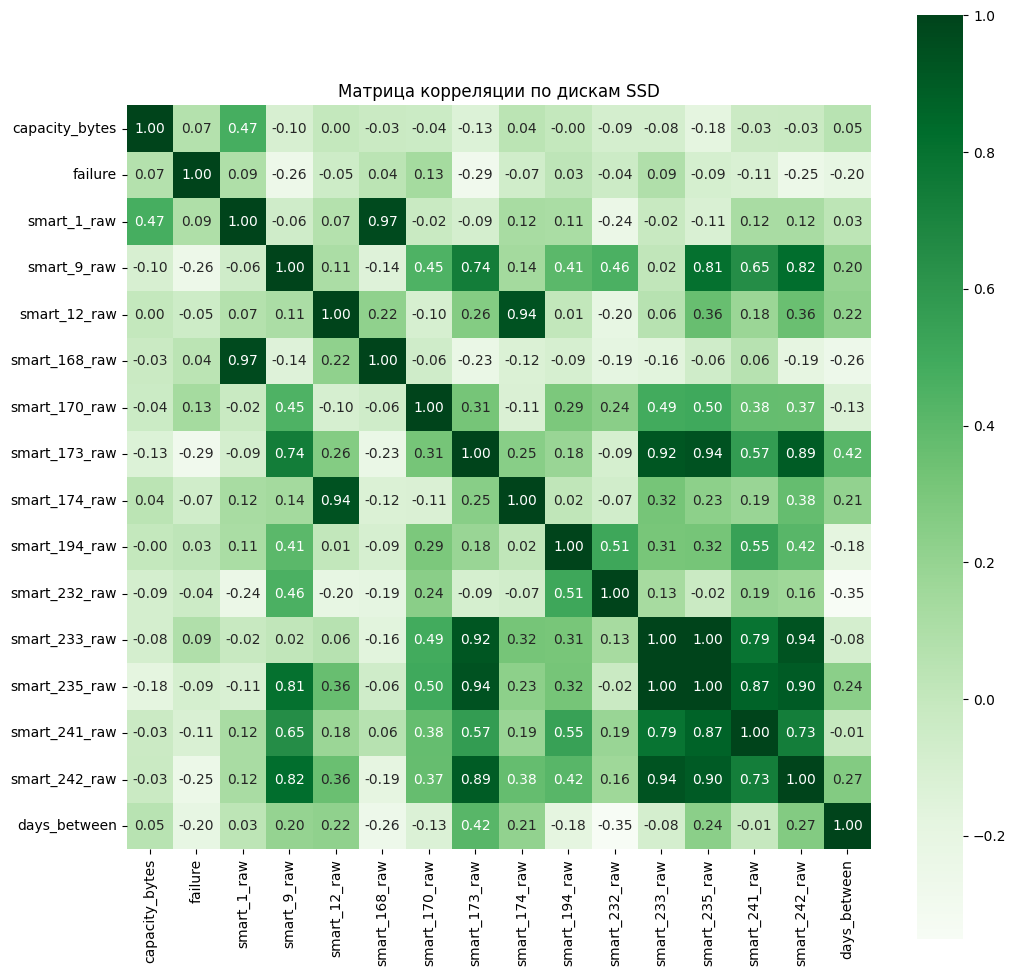

In [31]:
plt.title('Матрица корреляции по дискам SSD')
sns.heatmap(
    corr_matrix,
    cmap="Greens",
    fmt=".2f",
    annot=True,
    square=True,
)
plt.yticks(rotation=0)
plt.show()

In [32]:
df_ssd.isna().sum().sort_values(ascending=False)

,0
smart_235_raw,60
smart_232_raw,31
smart_168_raw,31
smart_242_raw,30
smart_1_raw,30
smart_241_raw,30
smart_170_raw,29
smart_173_raw,16
smart_174_raw,16
smart_233_raw,14


In [33]:
df_ssd.select_dtypes(include="number").apply(lambda col: (col == 0).sum())

,0
capacity_bytes,0
failure,112
smart_1_raw,161
smart_9_raw,3
smart_12_raw,0
smart_168_raw,132
smart_170_raw,27
smart_173_raw,0
smart_174_raw,18
smart_194_raw,0


In [34]:
corr_matrix_abs = df_ssd.select_dtypes(include='number').corr().abs()

upper_triangle = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(bool))
high_corr_pairs = [(column, row) for column in upper_triangle.columns for row in upper_triangle.index if upper_triangle.loc[row, column] > 0.80]

print("Пары признаков с корреляцией более 80%:")
for pair in high_corr_pairs:
    print(pair)

Пары признаков с корреляцией более 80%:
('smart_168_raw', 'smart_1_raw')
('smart_174_raw', 'smart_12_raw')
('smart_233_raw', 'smart_173_raw')
('smart_235_raw', 'smart_9_raw')
('smart_235_raw', 'smart_173_raw')
('smart_235_raw', 'smart_233_raw')
('smart_241_raw', 'smart_235_raw')
('smart_242_raw', 'smart_9_raw')
('smart_242_raw', 'smart_173_raw')
('smart_242_raw', 'smart_233_raw')
('smart_242_raw', 'smart_235_raw')


Описание датчиков:

- 174 - Число неожиданных отключений питания, когда питание было потеряно до получения команды на отключение диска.
- 12  - Количество полных циклов включения-выключения диска.
- 173 - Максимальное количество операций стирания, выполняемых для одного блока флэш-памяти.
- 233 - нет инфо
- 241 - У SSD Kingston — объём записанного за всё время жизни накопителя.
- 242 - нет инфо

Удалим столбцы с высокой корреляцией, возьмем те, у которых пропусков больше.

In [35]:
df_ssd = df_ssd.drop(
    columns=[
        "smart_174_raw",
        "smart_233_raw",
        "smart_235_raw",
        "smart_242_raw",
    ]
)

##### Missing

<Axes: >

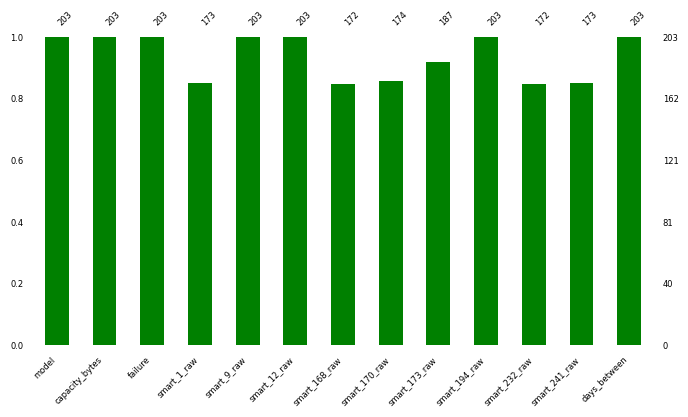

In [36]:
msno.bar(df_ssd, color="green", figsize=(8, 4), fontsize=6, labels=None)

Заполнять пропуски будет медианным значением, так как нет информации по ряду датчиков.

##### Description

In [37]:
df_ssd.describe().T

,count,mean,std,min,25%,50%,75%,max
capacity_bytes,203.00,"254,001,001,436.69","33,694,629,623.88","240,057,409,536.00","250,059,350,016.00","250,059,350,016.00","250,059,350,016.00","500,107,862,016.00"
failure,203.00,0.45,0.50,0.00,0.00,0.00,1.00,1.00
smart_1_raw,173.00,"16,174,100.30","212,733,000.81",0.00,0.00,0.00,0.00,"2,798,066,075.00"
smart_9_raw,203.00,"14,868.70","10,906.62",0.00,"4,891.00","14,545.00","23,953.50","44,501.00"
smart_12_raw,203.00,16.95,20.83,2.00,6.00,11.00,20.00,231.00
smart_168_raw,172.00,75.27,321.35,0.00,0.00,0.00,0.00,"2,761.00"
smart_170_raw,174.00,"52,798,477,382.53","215,750,515,495.96",0.00,89.25,107.50,169.00,"1,554,778,161,272.00"
smart_173_raw,187.00,"2,216,629,487,651.10","2,472,312,423,965.97",1.00,"491,540.50","1,284,217,307,535.00","3,659,370,496,952.50","8,950,850,783,367.00"
smart_194_raw,203.00,36.58,6.17,24.00,32.00,36.00,41.00,52.00
smart_232_raw,172.00,"170,275,476,735.04","216,200,570,319.54",0.00,0.00,97.50,"446,676,598,784.00","472,446,402,560.00"


In [38]:
df_ssd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 203 entries, 213 to 30813
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   model           203 non-null    object 
 1   capacity_bytes  203 non-null    int64  
 2   failure         203 non-null    int64  
 3   smart_1_raw     173 non-null    float64
 4   smart_9_raw     203 non-null    float64
 5   smart_12_raw    203 non-null    float64
 6   smart_168_raw   172 non-null    float64
 7   smart_170_raw   174 non-null    float64
 8   smart_173_raw   187 non-null    float64
 9   smart_194_raw   203 non-null    float64
 10  smart_232_raw   172 non-null    float64
 11  smart_241_raw   173 non-null    float64
 12  days_between    203 non-null    int64  
dtypes: float64(9), int64(3), object(1)
memory usage: 22.2+ KB


In [39]:
# df.groupby(["smart_168_raw", "failure"])["failure"].agg("count").to_frame(name="count")

##### Preprocessing

In [40]:
df_ssd.columns

Index(['model', 'capacity_bytes', 'failure', 'smart_1_raw', 'smart_9_raw',
       'smart_12_raw', 'smart_168_raw', 'smart_170_raw', 'smart_173_raw',
       'smart_194_raw', 'smart_232_raw', 'smart_241_raw', 'days_between'],
      dtype='object')

In [41]:
y = df_ssd[['failure', 'days_between']].copy()
y['failure'] = y['failure'].astype('bool')
X = df_ssd.drop(columns= ['failure', 'days_between', 'model'])

In [42]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('scaler', StandardScaler())
        ]),  X.select_dtypes(include="number").columns),

        # ('cat', Pipeline(steps=[
        #     ('encoder', OneHotEncoder(handle_unknown='ignore'))
        # ]), X.select_dtypes(exclude="number").columns)
      ]
    )

In [43]:
preprocessor.fit(X)
X= preprocessor.transform(X)
cols = [x.split("__")[-1] for x in preprocessor.get_feature_names_out()]

##### PLS

In [44]:
pls = PLSRegression()
pls.fit(X, y)

PLSRegression()

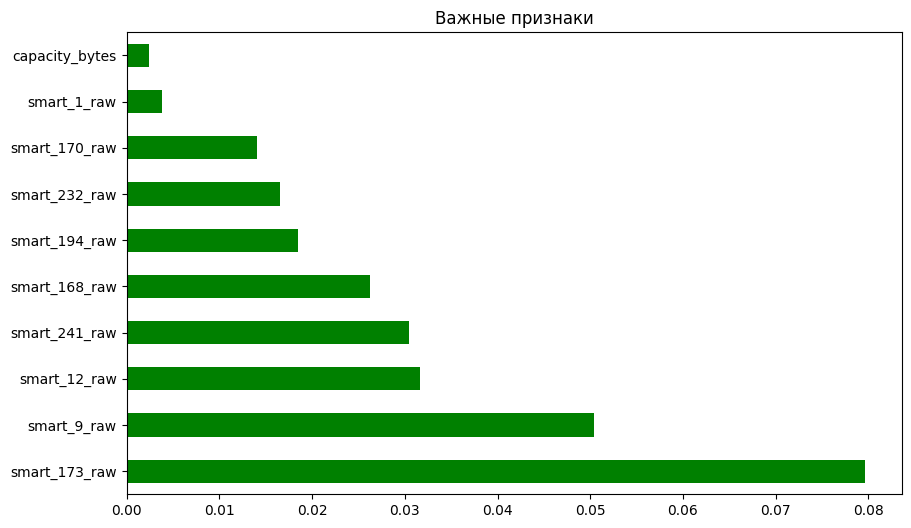

In [45]:
plt.figure(figsize=(10,6))
feature_importances = pd.Series(
    abs(pls.coef_[0]),
    index=cols,
).sort_values(ascending=False)

plt.title("Важные признаки")
feature_importances.plot(kind="barh", color='green')
plt.show()

##### Split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 1234)

In [47]:
y_train = Surv.from_dataframe('failure', 'days_between', y_train)
y_test = Surv.from_dataframe('failure', 'days_between', y_test)

##### Model

In [48]:
gc.collect()
rsf = RandomSurvivalForest(max_depth=5, n_estimators=50, random_state=1234, n_jobs=-1)
rsf.fit(X_train, y_train)

RandomSurvivalForest(max_depth=5, n_estimators=50, n_jobs=-1, random_state=1234)

In [49]:
rsf.score(X_train, y_train)

0.8708624708624708

In [50]:
rsf.score(X_test, y_test)

0.7415966386554622

In [51]:
gc.collect()

84

Посмотрим на важные признаки с точки зрения модели.

In [52]:
features = permutation_importance(rsf, X_test, y_test, n_repeats=5, random_state=1234)

In [53]:
pd.DataFrame(
    {
        k: abs(features[k])
        for k in (
            "importances_mean",
            # "importances_std",
        )
    },
    index=cols,
).sort_values(by="importances_mean", ascending=False)

,importances_mean
smart_173_raw,0.15
smart_12_raw,0.04
smart_194_raw,0.03
smart_9_raw,0.03
smart_241_raw,0.01
smart_1_raw,0.01
smart_168_raw,0.01
smart_170_raw,0.01
capacity_bytes,0.00
smart_232_raw,0.00


<div class="alert alert-success">
<h3>Вывод:</h3>
Для SSD дисков в модели будем использовать следующие:

- smart_9_raw
- smart_241_raw
- smart_12_raw
- smart_194_raw
- smart_173_raw
- smart_168_raw
- smart_170_raw
- smart_232_raw
- smart_1_raw
- capacity_bytes
- smart_241_raw

### HDD

Создадим отдельный датафрейм

In [54]:
df_hdd = df[~mask]

In [55]:
df_hdd.failure.value_counts()

,count
failure,
0,19018
1,11586


In [56]:
missing_cols = (df_hdd.isnull().mean() * 100).to_frame(name='null').reset_index()
missing_cols.shape

(100, 2)

Выделим колонки с более чем 30% пропусков и удалим их

In [57]:
cols_to_del = missing_cols.loc[missing_cols['null'] > 30]
print('Кол-во колонок с более 30% пропусков - ', cols_to_del.shape[0])

Кол-во колонок с более 30% пропусков -  78


In [58]:
df_hdd = df_hdd.drop(columns=cols_to_del.iloc[:, 0])

In [59]:
df_hdd.shape

(30604, 22)

In [60]:
df_hdd.drop(columns=['serial_number', 'date', 'type'], inplace=True)

In [61]:
df_hdd.describe(include='object')

,model
count,30604
unique,49
top,ST12000NM0008
freq,4094


##### Correlation

Посмотрим корреляцию признаков.

In [62]:
corr_matrix = df_hdd.select_dtypes(include='number').corr()

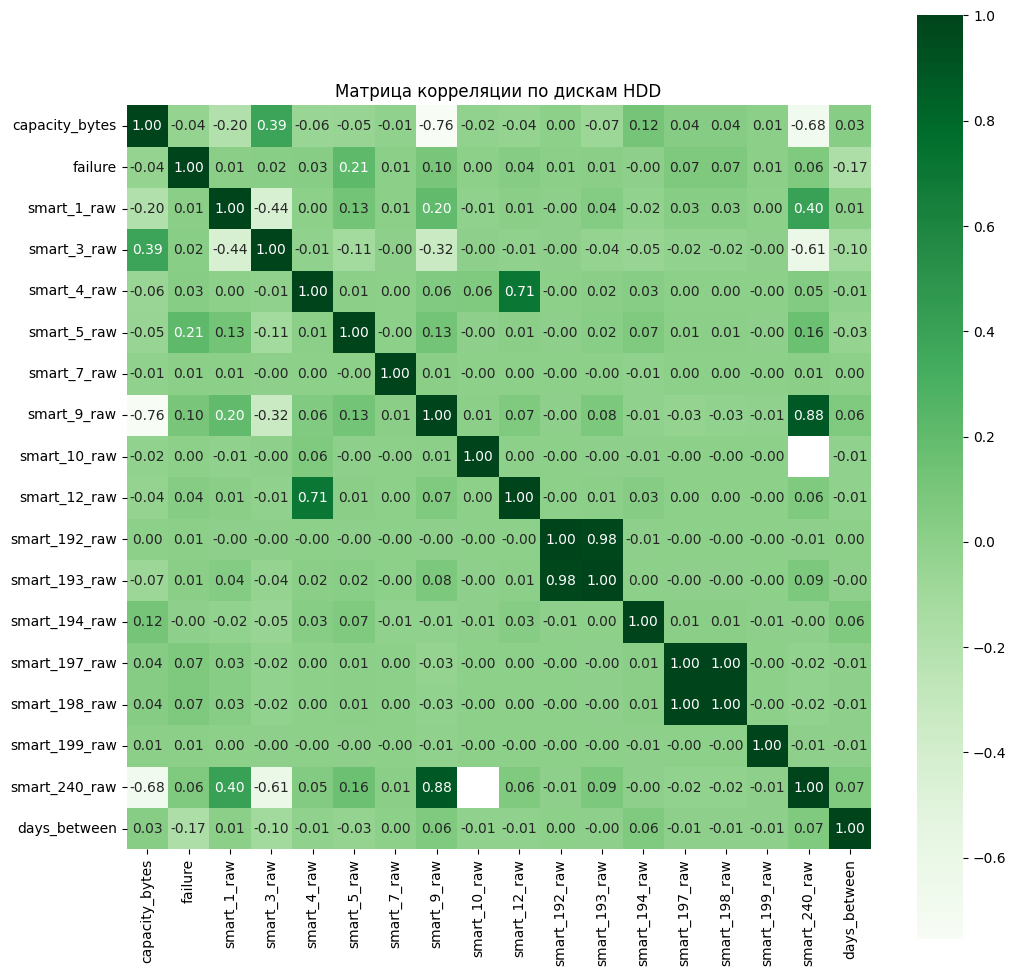

In [63]:
plt.title('Матрица корреляции по дискам HDD')
sns.heatmap(
    corr_matrix,
    cmap="Greens",
    fmt=".2f",
    annot=True,
    square=True,
)
plt.yticks(rotation=0)
plt.show()

In [64]:
corr_matrix_abs = corr_matrix.abs()

upper_triangle = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(bool))
high_corr_pairs = [(column, row) for column in upper_triangle.columns for row in upper_triangle.index if upper_triangle.loc[row, column] > 0.80]

print("Пары признаков с корреляцией более 80%:")
for pair in high_corr_pairs:
    print(pair)

Пары признаков с корреляцией более 80%:
('smart_193_raw', 'smart_192_raw')
('smart_198_raw', 'smart_197_raw')
('smart_240_raw', 'smart_9_raw')


Описание датчиков:
- 192 - Число циклов выключений или аварийных отказов (включений/выключений питания накопителя).
- 193 - Количество циклов перемещения блока магнитных головок в парковочную зону/в рабочее положение.
- 197 - Число секторов, являющихся кандидатами на замену. Рост значения этого атрибута может свидетельствовать о физической деградации жёсткого диска.
- 198 - Число некорректируемых (средствами диска) секторов.
- 9 - Число часов (минут, секунд — в зависимости от производителя), проведённых во включенном состоянии.
- 240 - Общее время нахождения блока головок в рабочем положении в часах.

Корреляция логически объяснима.
Посмотрим, какие пропуски остались и удалим столбцы с сильной корреляцией, из пары тот - где больше пропусков.

##### Missing

<Axes: >

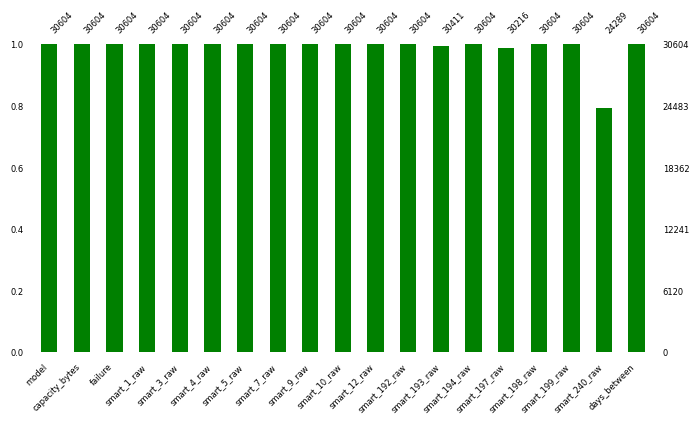

In [65]:
msno.bar(df_hdd, color="green", figsize=(8, 4), fontsize=6, labels=None)

In [66]:
df_hdd = df_hdd.drop(columns = ['smart_197_raw', 'smart_193_raw', 'smart_240_raw'])

In [67]:
df_hdd.isna().sum()

,0
model,0
capacity_bytes,0
failure,0
smart_1_raw,0
smart_3_raw,0
smart_4_raw,0
smart_5_raw,0
smart_7_raw,0
smart_9_raw,0
smart_10_raw,0


Пропусков больше нет. Но на их случай, в препроцессинге сделаем заполнение по медианному значению.


In [68]:
gc.collect()

27889

##### Description

In [69]:
df_hdd.describe().T

,count,mean,std,min,25%,50%,75%,max
capacity_bytes,"30,604.00","10,547,054,199,473.80","4,151,477,607,799.20","500,107,862,016.00","8,001,563,222,016.00","12,000,138,625,024.00","14,000,519,643,136.00","22,000,969,973,760.00"
failure,"30,604.00",0.38,0.49,0.00,0.00,0.00,1.00,1.00
smart_1_raw,"30,604.00","76,498,658.59","81,579,292.51",0.00,0.00,"48,967,636.00","146,642,178.00","1,058,619,411.00"
smart_3_raw,"30,604.00","1,314.88","2,817.23",0.00,0.00,0.00,380.00,"10,891.00"
smart_4_raw,"30,604.00",16.56,86.68,1.00,5.00,10.00,16.00,"4,230.00"
smart_5_raw,"30,604.00","1,773.71","7,330.11",0.00,0.00,0.00,20.25,"65,528.00"
smart_7_raw,"30,604.00","13,299,081,278.39","1,635,141,938,726.81",0.00,0.00,"251,168,985.00","787,346,606.25","281,471,003,655,490.00"
smart_9_raw,"30,604.00","31,262.15","18,262.40",0.00,"16,390.00","29,404.00","45,431.50","82,990.00"
smart_10_raw,"30,604.00",241.98,"19,016.09",0.00,0.00,0.00,0.00,"1,638,405.00"
smart_12_raw,"30,604.00",14.75,61.76,0.00,5.00,10.00,16.00,"3,873.00"


In [70]:
df_hdd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30604 entries, 0 to 30900
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   model           30604 non-null  object 
 1   capacity_bytes  30604 non-null  int64  
 2   failure         30604 non-null  int64  
 3   smart_1_raw     30604 non-null  float64
 4   smart_3_raw     30604 non-null  float64
 5   smart_4_raw     30604 non-null  float64
 6   smart_5_raw     30604 non-null  float64
 7   smart_7_raw     30604 non-null  float64
 8   smart_9_raw     30604 non-null  float64
 9   smart_10_raw    30604 non-null  float64
 10  smart_12_raw    30604 non-null  float64
 11  smart_192_raw   30604 non-null  float64
 12  smart_194_raw   30604 non-null  float64
 13  smart_198_raw   30604 non-null  float64
 14  smart_199_raw   30604 non-null  float64
 15  days_between    30604 non-null  int64  
dtypes: float64(12), int64(3), object(1)
memory usage: 4.0+ MB


##### Preprocessing

In [71]:
y = df_hdd[['failure', 'days_between']].copy()
y['failure'] = y['failure'].astype('bool')
X = df_hdd.drop(columns= ['failure', 'days_between', 'model'])

In [72]:
num_feat =  X.select_dtypes(include="number")
len(num_feat.columns)

13

In [73]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('scaler', StandardScaler())
        ]),  X.select_dtypes(include="number").columns),
      ]
    )

In [74]:
preprocessor.fit(X)
X= preprocessor.transform(X)
cols = [x.split("__")[-1] for x in preprocessor.get_feature_names_out()]

In [75]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(X)
normalized_df = pd.DataFrame(normalized_data, columns=cols)

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.

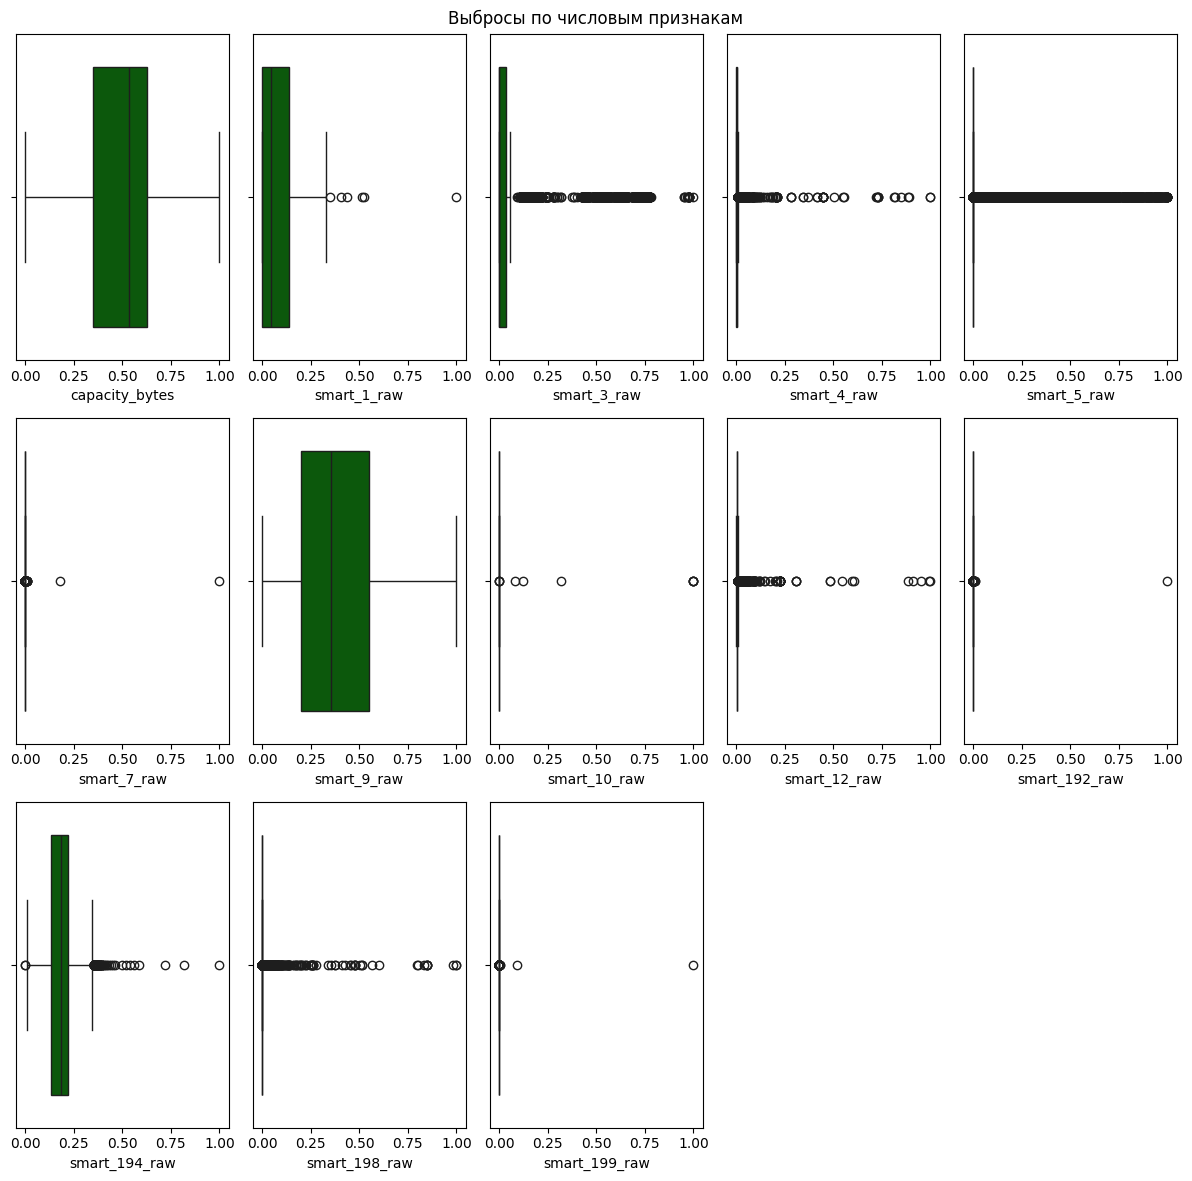

In [76]:
fig, ax = plt.subplots(3, 5)
fig.suptitle("Выбросы по числовым признакам")
i, j = 0, 0

for feat in num_feat.columns:
    sns.boxplot(
        normalized_df,
        x=feat,
        ax=ax[i][j],
        color="darkgreen",
    )
    j += 1
    if j == 5:
        i += 1
        j = 0
ax[2][3].remove()
ax[2][4].remove()
plt.tight_layout()
plt.show()


In [77]:
df.smart_199_raw.value_counts()

,count
smart_199_raw,
0.00,30158
1.00,61
4.00,33
3.00,27
5.00,26
...,...
"819,109.00",1
"1,324.00",1
"1,978.00",1


Выбросы в данных - это большие показания датчиков, сигнализирующие о проблемах.

##### PCA

Посмотрим, какие признаки оставить для модели с помощью методов PCA и PLSRegression.

In [78]:
pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(X)

In [79]:
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

In [80]:
fig = px.line(
    x=range(X_pca.shape[1]),
    y=cum_var_exp,
    markers=True,
    labels={"x": "Кол-во признаков", "y": "Объясненный коэффициент дисперсии"},
    title='Объясненная кумулятивная дисперсия по признакам'
)
fig.update_traces(line_color='green', line_width=5)
fig.show()

PCA говорит о том, что можно оставить все признаки.

In [81]:
gc.collect()

52

##### PLS

In [82]:
from sklearn.cross_decomposition import PLSRegression

pls = PLSRegression()
pls.fit(X, y)

PLSRegression()

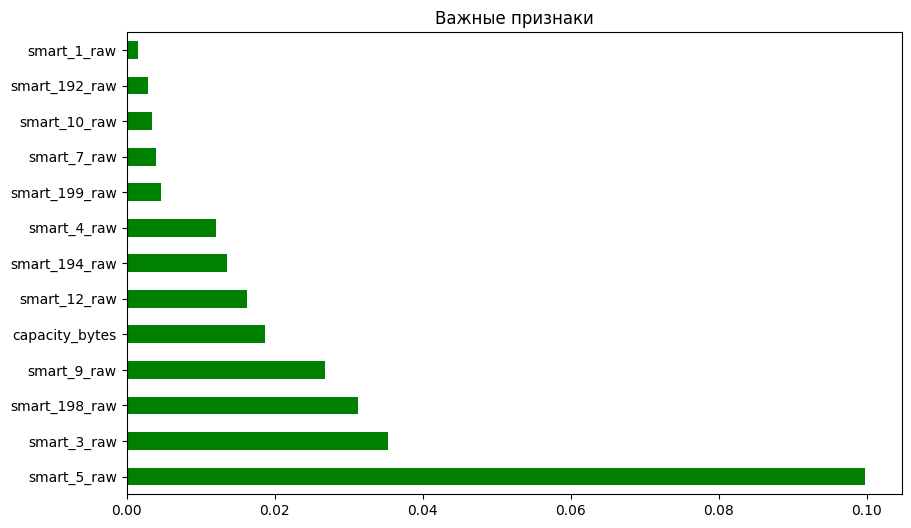

In [83]:
plt.figure(figsize=(10,6))
feature_importances = pd.Series(
    abs(pls.coef_[0]),
    index=cols,
).sort_values(ascending=False)

plt.title("Важные признаки")
feature_importances.plot(kind="barh", color='green')
plt.show()

##### VIF

Посмотрим корреляцию методом VIF и удалим сильно коррелирующие с остальными столбцы.

In [84]:
corr_matrix = np.array(pd.DataFrame(X).corr())
inv_corr_matrix = np.linalg.inv(corr_matrix)
mult_corr_feat = pd.DataFrame(np.diag(inv_corr_matrix), index=cols, columns=["VIF"]).sort_values(
    by="VIF", ascending=False
).reset_index()
mult_corr_feat#.style.background_gradient(cmap="Greens")

,index,VIF
0,capacity_bytes,2.57
1,smart_9_raw,2.42
2,smart_4_raw,2.03
3,smart_12_raw,2.02
4,smart_3_raw,1.42
5,smart_1_raw,1.26
6,smart_194_raw,1.05
7,smart_5_raw,1.04
8,smart_10_raw,1.01
9,smart_198_raw,1.00


Сильно коррелирующих признаков не обнаружено.

In [85]:
df.shape

(30807, 100)

In [86]:
gc.collect()

4545

##### Split

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 1234)

In [88]:
y_train = Surv.from_dataframe('failure', 'days_between', y_train)
y_test = Surv.from_dataframe('failure', 'days_between', y_test)

##### Model

In [89]:
gc.collect()
rsf = RandomSurvivalForest(
    max_depth = 10,
    n_estimators=50,
    random_state=1234,
    n_jobs=-1)
rsf.fit(X_train, y_train)

RandomSurvivalForest(max_depth=10, n_estimators=50, n_jobs=-1,
                     random_state=1234)

In [90]:
rsf.score(X_train, y_train)

0.738960956652036

In [91]:
rsf.score(X_test, y_test)

0.7137791710362951

In [92]:
gc.collect()

56

Посмотрим на важные признаки с точки зрения модели.

In [93]:
result = permutation_importance(rsf, X_test, y_test, n_repeats=5, random_state=1234)

In [94]:
pd.DataFrame(
    {
        k: abs(result[k])
        for k in (
            "importances_mean",
            # "importances_std",
        )
    },
    index=cols,
).sort_values(by="importances_mean", ascending=False)

,importances_mean
smart_5_raw,0.08
smart_198_raw,0.06
smart_3_raw,0.03
smart_9_raw,0.02
capacity_bytes,0.01
smart_7_raw,0.01
smart_192_raw,0.01
smart_12_raw,0.01
smart_194_raw,0.00
smart_4_raw,0.00


<div class="alert alert-success">
<h3>Вывод:</h3>
Для HDD дисков главные признаки следующие:

- capacity_bytes
- smart_1_raw
- smart_3_raw
- smart_4_raw
- smart_5_raw
- smart_7_raw
- smart_9_raw
- smart_12_raw
- smart_192_raw
- smart_194_raw
- smart_198_raw
- smart_10_raw
- smart_199_raw

<h2>Общий вывод:</h2>
Разделение дисков по группам не дает хороший результат по дискам SSD, так как их очень мало представлено в данных.
Необходимо выделить общие важные признаки для обоих типов дисков.

## <div style="border: 1px solid purple; padding: 10px; color: SteelBlue"> 4. Model</div>

Общими для двух типов дисков являются следующие датчики:

- capacity_bytes
- smart_1_raw
- smart_9_raw
- smart_12_raw
- smart_194_raw

Важнейшими для HDD:
- smart_5_raw
- smart_198_raw
- smart_3_raw

In [95]:
y = df[["failure", "days_between"]].copy()
y["failure"] = y["failure"].astype("bool")
X = df[
    [
        "smart_1_raw",
        "smart_9_raw",
        "smart_3_raw",
        "smart_5_raw",
        "smart_198_raw",
        "smart_12_raw",
        "smart_194_raw",
        "type"
    ]
]

In [96]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
            ('scaler', StandardScaler())
        ]),  X.select_dtypes(include="number").columns),

        ('cat', Pipeline(steps=[
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), X.select_dtypes(exclude="number").columns)
      ]
    )


In [97]:
preprocessor.fit(X)
X= preprocessor.transform(X)
cols = [x.split("__")[-1] for x in preprocessor.get_feature_names_out()]

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 1234)

In [99]:
y_train = Surv.from_dataframe('failure', 'days_between', y_train)
y_test = Surv.from_dataframe('failure', 'days_between', y_test)

In [100]:
gc.collect()
rsf = RandomSurvivalForest(max_depth=12, n_estimators=50, random_state=1234, n_jobs=-1, min_samples_leaf=2)
rsf.fit(X_train, y_train)

RandomSurvivalForest(max_depth=12, min_samples_leaf=2, n_estimators=50,
                     n_jobs=-1, random_state=1234)

In [101]:
rsf.score(X_train, y_train)

0.7468703019863125

In [102]:
gc.collect()
rsf.score(X_test, y_test)

0.6981570199331893

In [103]:
model_pkl_file = "model.pkl"
with open(model_pkl_file, 'wb') as file:
  pickle.dump(rsf, file)

In [104]:
# from google.colab import files
# files.download('model.pkl')

In [105]:
gc.collect()

0

In [106]:
pred = rsf.predict_survival_function(X_test)
times = np.array([60, 90, 364])
data = []
for i in range(len(pred)):
  for t in times:
    data.append({
            'index': i,
            'Time': t,
            'Survival Probability': pred[i](t)
        })

In [107]:
res = pd.DataFrame(data)
res_ = pd.DataFrame(y_test).reset_index()
result= pd.merge(res, res_, on='index')

In [108]:
result.head(10)

,index,Time,Survival Probability,failure,days_between
0,0,60,0.97,True,"1,047.00"
1,0,90,0.97,True,"1,047.00"
2,0,364,0.85,True,"1,047.00"
3,1,60,0.99,False,848.00
4,1,90,0.98,False,848.00
5,1,364,0.93,False,848.00
6,2,60,0.97,True,723.00
7,2,90,0.97,True,723.00
8,2,364,0.80,True,723.00
9,3,60,0.97,True,128.00


In [109]:
result.to_csv('result.csv', index=False)

##### Grid Search

In [110]:
# model = RandomSurvivalForest(random_state=111)

# from sksurv.metrics import concordance_index_censored
# from sklearn.metrics import make_scorer
# def c_index_scorer(estimator, X, y):
#     pred_risk = estimator.predict(X)
#     result = concordance_index_censored(y['days_between'], y['failure'], pred_risk)
#     return result[0]

# c_index_scorer = make_scorer(c_index_scorer, greater_is_better=True)

# param_grid = dict(
#     max_depth=[3],
#     # min_samples_leaf=range(1, 6, 2),
#     # min_samples_split=range(2, 8, 2),
#     # n_estimators=range(50, 151, 50)
# )

# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     n_jobs=-1,
#     cv=3,
#     scoring=c_index_scorer,
#     verbose=False,
# )

# grid_search.fit(X_train, y_train)
# rsf = grid_search.best_estimator_